# Redes Complejas 2018: Trabajo Computacional 1
*Por Tomás Ferreira Chase, Matías Leizerovich y Gabriel Goren*

Este trabajo fue realizado en Python con `networkx` versión 2.x. Se empleó la librería `rpy2` para llamar a la función `fit_power_law` de la librería `igraph` de R en el Ejercicio 3.

## Ejercicio 1: Proteínas

En este ejercicio, nos familiarizamos con el manejo más básico de redes empleando la librería `networkx` así como con algunas cantidades que podemos medir sobre las mismas.

Primero importamos las librerías que precisamos.

In [6]:
from lectura import ldata
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from __future__ import division # Compatibilidad con python2

Luego definimos algunas funciones que vamos a utilizar.

In [21]:
def es_dirigido(data):
    """Función que calcula un criterio para determinar, en ausencia
    de otra información, si un cierto grafo es o no es dirigido.
    
    Recibe la información de un grafo dada en forma de lista de
    enlaces (tuplas).
    
    El criterio implementado es básicamente el siguiente: si un mismo
    par de nodos aparece dos veces en la lista de enlaces, una en
    cada orden posible, entonces la red debe ser dirigida, puesto que
    de lo contrario se nos estaría proveyendo información redundante.
    
    Devuelve el número de veces que un par de nodos aparece repetido
    de esta manera. Si el resultado es 0, entonces es no dirigido; si
    es distinto de cero, es dirigido (según este criterio).
    
    
    """
    n = 0
    for (x, y) in data:
        for (a, b) in data:
            if a == y and b == x:
                n += 1
    return n/2

def k_medio(G):
    """Función que calcula el grado medio de un grafo, ya sea
    dirigido o no dirigido. """
    N = G.order()
    if isinstance(G, nx.DiGraph):
        kin_med = sum(k for (nodo, k) in G.in_degree) / N
        kout_med = sum(k for (nodo, k) in G.out_degree) / N
    else:
        kin_med, kout_med = 0, 0
    k_med = sum(k for (nodo, k) in G.degree) / N
    return kin_med, kout_med, k_med

def k_extremos(G):
    k_min = min(k for (nodo, k) in G.degree)
    k_max = max(k for (nodo, k) in G.degree)
    return k_min, k_max

def clustering_medio(G):
    return np.average(list(dict(nx.clustering(G)).values()))

Importamos las redes.

In [22]:
y2h = ldata('tc01_data/yeast_Y2H.txt')
apms = ldata('tc01_data/yeast_AP-MS.txt')
lit = ldata('tc01_data/yeast_LIT.txt')

In [23]:
g_y2h = nx.Graph()
g_y2h.add_edges_from(y2h)

g_apms = nx.Graph()
g_apms.add_edges_from(apms)

g_lit = nx.Graph()
g_lit.add_edges_from(lit)

### Punto a

En primer lugar visualizamos las redes que hemos importado. Según nos indica la consigna, se trata de redes de interacción de proteínas relevadas para levadura, por lo cual podemos decir que las tres redes representan un mismo sistema físico.

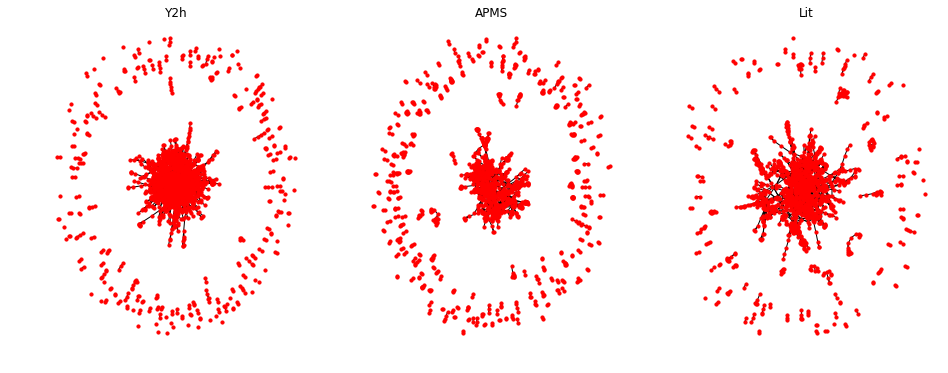

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

ax1.set_title('Y2h')
nx.draw(g_y2h, node_size = 10, ax=ax1)

ax2.set_title('APMS')
nx.draw(g_apms, node_size = 10, ax=ax2)

ax3.set_title('Lit')
nx.draw(g_lit, node_size = 10, ax=ax3)

plt.show()

Podemos ver que se trata de redes grandes, que presentan una componente gigante. Graficando solo estas últimas:

In [28]:
# Construimos los subgrafos correspondientes a las componentes gigantes
gc_y2h = max(nx.connected_component_subgraphs(g_y2h), key=len)
gc_apms = max(nx.connected_component_subgraphs(g_apms), key=len)
gc_lit = max(nx.connected_component_subgraphs(g_lit), key=len)

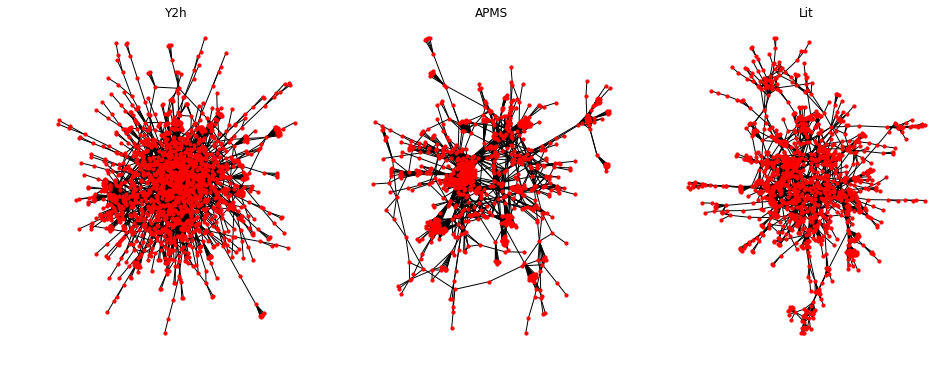

In [30]:
# Los graficamos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

ax1.set_title('Y2h')
nx.draw(gc_y2h, node_size = 10, ax=ax1)

ax2.set_title('APMS')
nx.draw(gc_apms, node_size = 10, ax=ax2)

ax3.set_title('Lit')
nx.draw(gc_lit, node_size = 10, ax=ax3)

plt.show()

Vemos que el algoritmo de visualización por defecto de `networkx` (posicionamiento de nodos por resortes) grafica las 3 redes de maneras bastante diferentes, con lo cual podemos suponer que hay diferencias significativas en los datos aún si representan al mismo sistema físico.

### Punto b

#### Sobre si las redes son o no son dirigidas

En principio, al comenzar a trabajar con una red es esencial que se nos informe si la red es o no dirigida, dado que esta información no está contenida en la lista de enlaces, y cambia muchísimo la interpretación física de la red.

Ante la ausencia de un metadato claro sobre si los enlaces importados deben ser considerados dirigidos o no dirigidos, se implementó la función `es_dirigido` que permite evaluar un criterio posible para determinar, para cada red, de qué tipo de enlaces se trata. El criterio es simple, si bien falible: si un mismo par de nodos aparece dos veces en la lista de enlaces, una en cada orden posible, entonces la red debe ser dirigida, puesto que de lo contrario se nos estaría proveyendo información redundante. Puede fallar debido a que también es posible que los datos simplemente estén presentados de manera poco prolija.

Aplicando la función, obtenemos lo siguiente.

In [41]:
for nombre, datos in [('Y2H', y2h), ('AP-MS', apms), ('Lit', lit)]:
    print('Los datos de la red {} tienen {} pares de nodos repetidos.'.format(nombre, es_dirigido(datos)))

Los datos de la red Y2H tienen 112.5 pares de nodos repetidos.
Los datos de la red AP-MS tienen 0.0 pares de nodos repetidos.
Los datos de la red Lit tienen 40.5 pares de nodos repetidos.


Este criterio parecería indicar que las redes Y2H y Lit son dirigidas. Sin embargo, la cantidad de pares de nodos que aparecen repetidos es muy chica respecto del tamaño total de la red (ver la tabla más abajo), por lo cual también es factible que se trate de datos mal presentados.

En última instancia, se recurrió al significado biológico de las redes para determinar su naturaleza: debido a que estamos hablando de interacciones entre proteínas, relacionadas con el posible acoplamiento mecánico entre las mismas, no tiene mucho sentido considerar que dichas interacciones puedan ser dirigidas.

De esta manera, se trabajó con las redes considerándolas no dirigidas, salvo que se diga lo contrario.

Presentamos entonces una tabla con todos los datos pedidos, y luego procedemos a mostrar cómo calculamos cada uno de ellos.

In [27]:
data = pd.DataFrame({"Nombre de la red": ['Y2H','AP-MS','Lit'],
                     "N":[2018,1622,1536],
                     "L":[2930,9070,2925],
                     "Dirigida?":['No','No','No'],
                     "$$\overline{K}$$":[2.9038652130822595,11.183723797780518,3.80859375],
                     "$$\overline{K_{in}}$$":[1.4519326065411298,'-',1.904296875],
                     "$$\overline{K_{out}}$$":[1.4519326065411298,'-',1.904296875],
                     "$$K_{min}$$":[1,1,1],
                     "$$K_{max}$$":[91,127,40],
                     "Densidad":[0.0014396951973635397,0.006899274397150227,0.002481168566775244],
                     "$$<C_{i}>$$":[0.046194001297365124,0.5546360657013015,0.2924923005815713],
                     "$$C_{\Delta}$$":[0.02361415364051535, 0.6185901626483971, 0.3461926495315878],
                     "Diametro (para la componente gigante)":[14,15,19],
                    })#empty dataframe
data

,Nombre de la red,N,L,Dirigida?,$$\overline{K}$$,$$\overline{K_{in}}$$,$$\overline{K_{out}}$$,$$K_{min}$$,$$K_{max}$$,Densidad,$$<C_{i}>$$,$$C_{\Delta}$$,Diametro (para la componente gigante)
0,Y2H,2018,2930,No,2.903865,1.45193,1.45193,1,91,0.001440,0.046194,0.023614,14
1,AP-MS,1622,9070,No,11.183724,-,-,1,127,0.006899,0.554636,0.618590,15
2,Lit,1536,2925,No,3.808594,1.9043,1.9043,1,40,0.002481,0.292492,0.346193,19


Para calcular cuantos nodos hay:

In [ ]:
print('El número de nodos de cada grafo es',
      g_y2h.order(), g_apms.order(), g_lit.order()) 

Para calcular cuantos enlaces hay:

In [ ]:
print('El número de enlaces para cada grafo es',
      g_y2h.size(), g_apms.size(), g_lit.size())

Para calcular el grado medio, lo hacemos considerando a las redes Y2H y Lit como no dirigidas y también como dirigidas, tal como habría sugerido el criterio considerado inicialmente. De esta manera, calculamos el grado medio (sin tener en cuenta la dirección de los enlaces) para las 3 redes, y además el grado medio de entrada $\overline{K_{in}}$ y de salida $\overline{K_{out}}$ para esas dos redes dirigidas.

In [55]:
# Creamos versiones dirigidas de las redes Y2H y Lit
g_lit_Di = nx.DiGraph()
g_lit_Di.add_edges_from(lit)

g_y2h_Di = nx.DiGraph()
g_y2h_Di.add_edges_from(y2h)

In [56]:
kin_medio_lit, kout_medio_lit, k_medio_lit = k_medio(g_lit_Di)
kin_medio_y2h, kout_medio_y2h, k_medio_y2h = k_medio(g_y2h_Di)
print('Grados medios calculados usando grafos dirigidos (Y2h y Lit)')
print('Grados medios')
print(k_medio_y2h, k_medio_lit)
print('Grados medios in')
print(kin_medio_y2h, kin_medio_lit)
print('Grados medios out')
print(kout_medio_y2h, kout_medio_lit)

print()
_, _, k_medio_apms = k_medio(g_apms)
_, _, k_medio_lit = k_medio(g_lit)
_, _, k_medio_y2h = k_medio(g_y2h)
print('Grados medios calculados usando grafos no dirigidos:')
print('Y2H, AP-MS, Lit')
print(k_medio_y2h, k_medio_apms, k_medio_lit)

Grados medios calculados usando grafos dirigidos (Y2h y Lit)
Grados medios
2.9038652130822595 3.80859375
Grados medios in
1.4519326065411298 1.904296875
Grados medios out
1.4519326065411298 1.904296875

Grados medios calculados usando grafos no dirigidos:
Y2H, AP-MS, Lit
2.9038652130822595 11.183723797780518 3.80859375


Comparando los valores para redes dirigidas y no dirigidas, vemos que
- Para las redes dirigidas,  $\overline{K_{in}}$ y $\overline{K_{out}}$ son iguales. Esto es cierto un poco trivialmente, dado que cada enlace dirigido es un enlace de salida de un nodo y un enlace de entrada para otro. Se puede entender también así: si pensamos en una red en donde existen 2 nodos que no estan conectados entre sí, y ahora tendemos un enlace dirigido entre ambos, tanto $\overline{K_{in}}$ como $\overline{K_{out}}$ aumentaran.
- La $\overline{K_{in}} + \overline{K_{out}} = \overline{K}$ donde $\overline{K}$ es el grado medio de la red no dirigida correspondiente.

Para calcular los grados máximo y el grado mínimo:

In [57]:
k_min_apms, k_max_apms = k_extremos(g_apms)
k_min_lit, k_max_lit = k_extremos(g_lit)
k_min_y2h, k_max_y2h = k_extremos(g_y2h)
print('Grados extremos')
print('K_min:', k_min_y2h,  k_min_apms, k_min_lit)
print('K_max:', k_max_y2h,  k_max_apms, k_max_lit)

Grados extremos
K_min: 1 1 1
K_max: 91 127 40


Para calcular la densidad de la red, usamos la función nx.density.

In [58]:
print('La densidad de las redes es', nx.density(g_y2h), nx.density(g_apms), nx.density(g_lit))

La densidad de las redes es 0.0014396951973635397 0.006899274397150227 0.002481168566775244


En relación al clustering, vamos a calcular dos coeficientes diferentes. El primero ($\left<C_i\right>$) es un promedio entre los coeficientes de cluesting local de cada nodo de la red. El segundo ($C_\Delta$) es un coeficiente de clustering global que mide la proporción de triganulo formados en la red sobre el número de triadas de la misma.

- $\left<C_i\right>$ responde a la pregunta: “¿En qué medida pares de vecinos de un nodo tomado al azar en la red son vecinos entre sí?”
- $C_\Delta$ responde a la pregunta: “¿Qué tan probable es encontrar triangulos (a.k.a. clausura transitiva) en la red?”

In [59]:
print('C_Δ')
print (nx.transitivity(g_y2h), nx.transitivity(g_apms),
       nx.transitivity(g_lit))

print('<C_i>')
print(clustering_medio(g_y2h))
print(clustering_medio(g_apms))
print(clustering_medio(g_lit))

C_Δ
0.02361415364051535 0.6185901626483971 0.3461926495315878
<C_i>
0.046194001297365124
0.5546360657013015
0.2924923005815713


Observación: El método $C_\Delta$ no diferencia entre enlaces entrantes y salientes en redes dirigidas. El método $\left<C_i\right>$ no está definido para redes dirigidas.

Para calcular el diámetro de la red, utilizamos la función nx.diameter. Dado que los 3 grafos son no conexos, como se puede ver en las visualizaciones del principio, su diámetro es convencionalmente definido como infinito. Para obtener un resultado más informativo, consideramos únicamente sus componentes gigantes, las cuales ya fueron construidas más arriba.

In [61]:
print('Diámetro para la red Y2H', nx.diameter(gc_y2h))
print('Diámetro para la red AP-MS', nx.diameter(gc_apms))
print('Diámetro para la red Lit', nx.diameter(gc_lit))

Diámetro para la red Y2H 14
Diámetro para la red AP-MS 15
Diámetro para la red Lit 19


#### Discusión

- La red Y2H tiene casi un 25% más de nodos que las otras dos.
- La red AP-MS tiene muchísimos más enlaces que las otras dos, lo cual queda cuantificado por su densidad, la cual es aproximadamente 3 veces más grande que las demás. Esto se refleja en su grado medio, así como en sus coeficientes de clustering y el grado máximo alcanzado.
- La red Lit es la red más "larga", en el sentido de que tiene un mayor diámetro que las otras dos.

### Puntos c y d

Según lo hablado en la práctica, en vez de encarar estos puntos tal como están descritos en la guía, nos proponemos decidir entre dos métodos posibles que podrían haber sido implementados a la hora de construir la red AP-MS.

El aspecto relevante del método experimental para generar una red como nuestra red AP-MS es el siguiente. Se introducen en la célula anticuerpos que se "enganchan" a una determinada proteína A, y al hacerlo se terminan acoplando a todo un complejo de proteínas (e.g. ABCD). Luego se extrae de la célula lo que sea que el anticuerpo "atrapó", y se identifican las proteínas presentes en el complejo extraído (A, B, C y D por separado).

La ambigüedad se encuentra en que una red codifica interacciones binarias, mientras que este método permite relevar acoplamiento mecánico entre múltiples proteínas sin identificar realmente cuál se acopla con cuál. Dos maneras para meter esta interacción simultánea entre múltiples proteínas dentro de un contexto de relaciones binarias:

1) $G=\{A\leftrightarrow B,A\leftrightarrow C,A\leftrightarrow D\}$

2) $G=GrafoCompleto(A,B,C,D)$.

El primer método posiblemente subestima la cantidad real de interacciones mecánicas, mientras que el segundo la sobreestima.

Nos preguntamos entonces cuál de estos dos es el que se aplicó para obtener la red AP-MS bajo consideración.

En primer lugar, se observa que los coeficientes de clustering y la densidad de la red AP-MS es mayor que la de la red Y2H y la red Lit, que a su vez poseen densidad y clusterizacion similar.

Por otro lado, visualizando distintos sectores de la red, cualitativamente se observa que los enlaces presentes parecerían ser consistentes con haber sido generados mediante una superposición de cliques, i.e. se observan grupos de tamaño del orden de 10 nodos conectados completamente entre sí, y adicionalmente conectados mediante uno o dos nodos al resto de la red.

Estas dos observaciones sugieren fuertemente que el método adoptado en este caso fue el segundo, sobreestimando la cantidad de enlaces presentes en la red.

## Ejercicio 2

Importamos las librerías.

In [65]:
from __future__ import division
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.readwrite.gml import read_gml
from random import sample

from lectura import ldata
from histograma import histograma
from graficar_multipartito import *

from collections import Counter

Definimos las funciones que vamos a utilizar. Algunas funciones de visualización empleadas las importamos de archivos de código separados, para no congestionar el notebook.

In [73]:
#Para graficar
def genero_a_color(gender):
    if gender=='m':
        return 'red'
    elif gender=='f':
        return 'dodgerblue'
    else:
        return 'green'
    
def particionar_por_genero(G, orden={'f':0, 'NA':1, 'm':2}):
    particiones = [[], [], []]
    for key in dict(G.nodes).keys():
        gender = G.nodes[key]['gender']
        if gender=='f':
            particiones[orden[gender]].append(key)
        elif gender=='m':
            particiones[orden[gender]].append(key)
        else:
            particiones[orden[gender]].append(key)
    return particiones

def crear_leyenda(ax):
    ax.plot([],[], 'o', color='dodgerblue', label='Hembras')
    ax.plot([],[], 'o', color='red', label='Machos')
    ax.plot([],[], 'o', color='black', label='NA')
    ax.legend()

In [66]:
#Para cuantificar homofilia.
def contar_clases(g, atributo, valores_posibles):
    ns = []
    for valor in valores_posibles:
        n = len([n for n, attrdict in dict(g.nodes).items() if attrdict[atributo]==valor])
        ns.append(n)
        print('Hay {} nodos con {}={}'.format(n, atributo, valor))
    return ns

def contar_enlaces_internos(g, atributo, valor):
    """Cuenta los enlaces internos en el grupo de nodos que tienen
    atributo=valor. g debe ser objeto Graph de NetworkX.
    Ejemplo con delfines: atributo='gender', valor puede ser 'f', 'm' o 'NA'
    """
    nodos = [n for n, attrdict in dict(g.nodes).items() if attrdict[atributo]==valor]
    grupo = nx.subgraph(g, nodos)
    return grupo.size()

def contar_enlaces_entre_grupos(g, atributo):
    """Cuenta los enlaces que conectan grupos con valores distintos de
    atributo. g debe ser objeto Graph de NetworkX.
    Ejemplo con delfines: atributo='gender'.
    """
    n = 0
    for edge in g.edges():
        a, b = edge[0], edge[1]
        if g.nodes()[a][atributo] != g.nodes()[b][atributo]:
            n = n + 1
    return n

In [68]:
#Para el calculo de la modularidad
def modularidad(g, atributo):
    A = nx.adjacency_matrix(g)
    B = 0
    m = len(g.edges())
    k = []
    name = []
    for key, value in g.degree():
        k.append(value)
        name.append(key)
    for i in range(len(k)):
        for j in range(len(k)):
            if g.node[name[i]][atributo] == g.node[name[j]][atributo]:
                B += A[i, j] - k[i]*k[j]/(2*m)
    return float(B)/(2*m)

In [128]:
# Para calcular el p-value del número de enlaces entre delfines de distinto
# género, y de la modularidad de la red, bajo la hipótesis nula.

#def p_value(datos, valor_observado):
#    enlace = list(Counter(datos).keys())
#    cuantos = list(Counter(datos).values())
#    indices = np.where(np.array(enlace)<= valor_real)[0] 
#    a = [cuantos[i] for i in indices]
#    return 2 * len(a)/len(datos)

def p_value(datos, valor_observado, cola, doscolas=False):
    assert cola in ['izq', 'der']
    if cola == 'izq':
        frac = np.sum(datos <= valor_observado) / len(datos)
    else:
        frac = np.sum(datos >= valor_observado) / len(datos)
    if doscolas:
        return frac * 2
    else:
        return frac

Importamos la red de delfines y a cada uno le asignamos su género.

In [129]:
dolph = read_gml('tc01_data/new_dolphins.gml')
genders = dict(ldata('tc01_data/dolphinsGender.txt'))

# Agregamos los géneros a los dicts de cada delfín
for nodo, dict_nodo in dict(dolph.nodes).items():
    dict_nodo['gender'] = genders[nodo] # agrego el género del delfín a su dict
#    print('Key = {}, Value = {}'.format(nodo, dict_nodo)) # para chequear que anda

particiones = particionar_por_genero(dolph)
colores = [genero_a_color(g) for g in nx.get_node_attributes(dolph, "gender").values()]    

Hay 34 delfines macho, 24 delfines hembra y 4 delfines sin información.

### Punto a

Exploramos distintos tipos de visualizaciones, intentando que las mismas nos permitan observar cómo es el conexionado entre los delfines de distinto género, así como el conexionado interno de cada grupo. Para esto graficamos de 9 maneras diferentes.

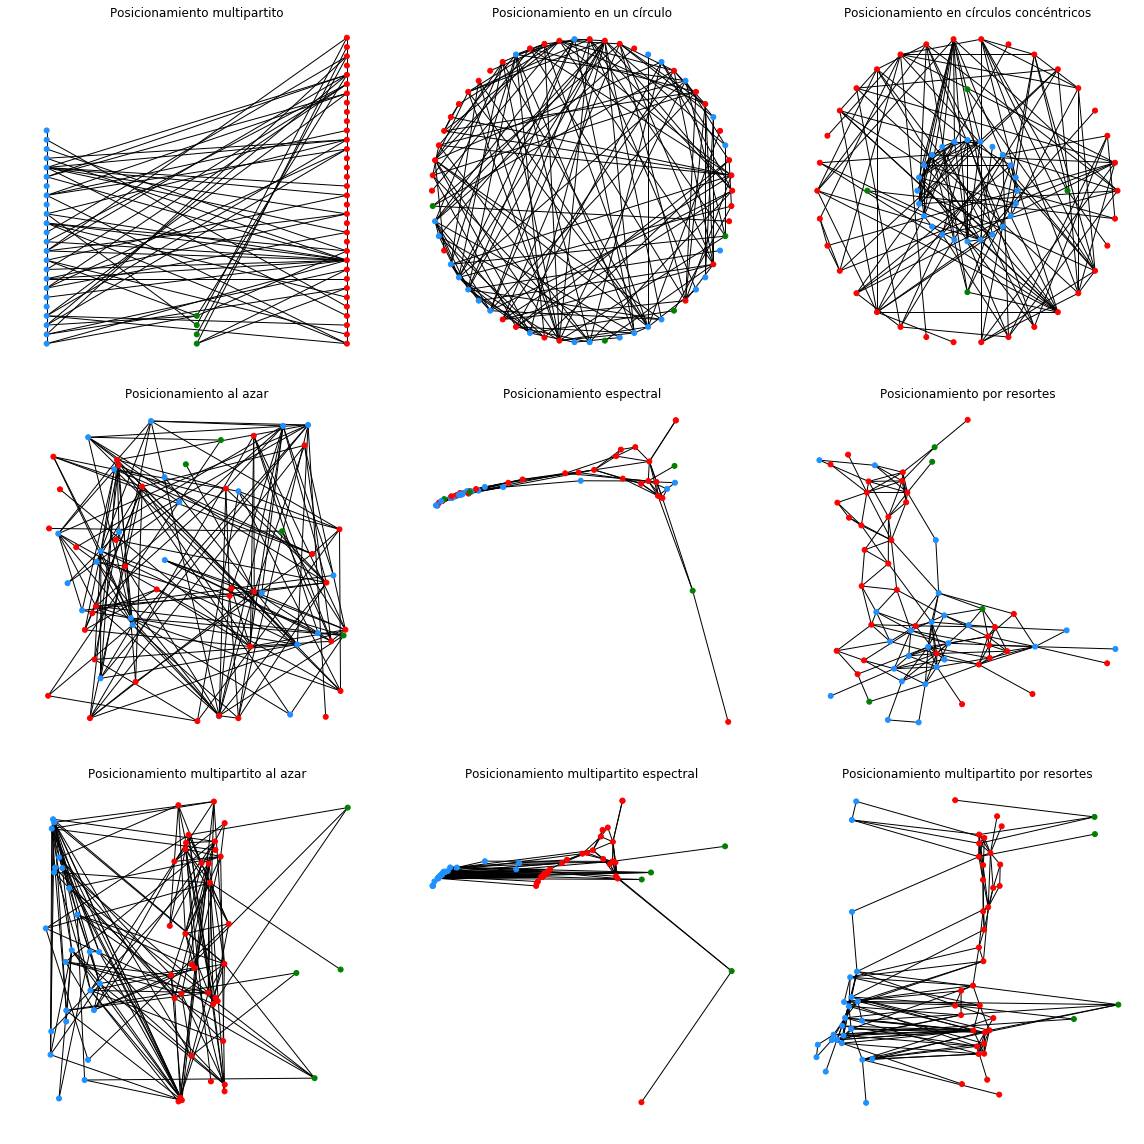

In [130]:
fig, axes = plt.subplots(3,3, figsize=(16, 16))
axes = axes.flatten()
ns = 25 # Node size

# Posicionamiento multipartito (es engañoso: no se ven los links homofílicos)
multipartite_pos = position_multipartito(dolph, ['f', 'NA', 'm'], 'gender')
nx.draw(dolph, ax = axes[0], node_size = ns, node_color=colores,
        pos=multipartite_pos)
axes[0].set_title('Posicionamiento multipartito')

# Posicionamiento en un círculo
nx.draw_circular(dolph, ax = axes[1], node_size = ns, node_color=colores)
axes[1].set_title('Posicionamiento en un círculo')

# Posicionamiento en círculos concéntricos
shell_pos = nx.drawing.layout.shell_layout(dolph, particiones)
nx.draw(dolph, ax = axes[2], node_size = ns, node_color=colores,
        pos=shell_pos)
axes[2].set_title('Posicionamiento en círculos concéntricos')

# Posicionamiento al azar
nx.draw_random(dolph, ax = axes[3], node_size = ns, node_color=colores)
axes[3].set_title('Posicionamiento al azar')

# Posicionamiento espectral
nx.draw_spectral(dolph, ax = axes[4],
                 node_size = ns, node_color=colores)
axes[4].set_title('Posicionamiento espectral')

# Posicionamiento por resortes
nx.draw_spring(dolph, ax = axes[5],
                 node_size = ns, with_labels=False, node_color=colores)
axes[5].set_title('Posicionamiento por resortes')

# Posicionamiento multipartito al azar. Posiciono al azar y
# luego desplazo lateralmente según género

multi_random_pos = position_multipartito_random(dolph,
                                                ['f', 'm', 'NA'], 'gender')
nx.draw(dolph, ax = axes[6], node_size = ns, node_color=colores,
        pos=multi_random_pos)
axes[6].set_title('Posicionamiento multipartito al azar')


# Posicionamiento multipartito espectral. Posiciono por espectro y
# luego desplazo lateralmente según género
multi_spectral_pos = position_multipartito_spectral(dolph,
                                                    ['f', 'm', 'NA'], 'gender', dhorizontal=0.5)
nx.draw(dolph, ax = axes[7], node_size = ns, node_color=colores,
        pos=multi_spectral_pos)
axes[7].set_title('Posicionamiento multipartito espectral')

# Posicionamiento multipartito por resortes. Posiciono por resortes y
# luego desplazo lateralmente según género
multi_spring_pos = position_multipartito_spring(dolph, ['f', 'm', 'NA'],
                                                'gender', dhorizontal=2)
nx.draw(dolph, ax = axes[8], node_size = ns, node_color=colores,
        pos=multi_spring_pos)
axes[8].set_title('Posicionamiento multipartito por resortes')

fig.tight_layout()
plt.show()

En todas las visualizaciones, el color celeste indica delfín hembra y el colón rojo indica delfín macho. El color verde indica ausencia de información.

- La visualización 1 ("layout multipartito") no es para nada adecuada en nuestro caso debido a que nuestra red no es multipartita, y no es posible ver claramente los links entre nodos de un mismo grupo.
- Las visualizaciones circulares tampoco resultan particularmente informativas, a pesar de que en los círculos concéntricos se distinguen claramente los diferentes grupos. Pasa algo parecido a lo que ocurre con el "layout multipartito".
- Entre las visualizaciones al azar, espectral y por resortes, la visualización por resortes parece ser la más clara para observar qué subgrupos de nodos se conectan más con cuáles. La visualización espectral se ve interesante pero no sabemos interpretarla.
- En la visualización por resortes, se observa que existen dos grupos de delfines que interactuan mayormente entre sí, uno de los cuales es transversal a la división por género.
- En las últimas 3 visualizaciones, realizamos un desplazamiento lateral de los nodos según su información de género (ver archivo `graficar_multipartito.py`). En el caso de la visualización por resortes, esto permite observar mejor lo dicho anteriormente: puede notarse que un cluster tiene aproximadamente la misma cantidad de delfines hembras que machos, mientras que el otro está compuesto principalmente por machos.

## Punto b

Primero vamos a quedarnos con un subgrafo del original, en donde elminamos los nodos con genero no definido.

In [131]:
delfines_con_info = [d for d in dolph.nodes() if d not in particiones[1]]
dolph2 = nx.subgraph(dolph, delfines_con_info).copy()

Lo que hacemos en este punto es generar mediante Monte Carlo una aproximación a la distribución de probabilidad del número de enlaces entre delfines de distinto género bajo la hipótesis nula de que la topología y la información de género son independientes. Para ello generamos 100.000 variantes de la red observada, redistribuyendo aleatoriamente los géneros de los nodos según una distribución uniforme.

In [142]:
n_simulaciones = int(1e5)
enlaces_entre_grupos = np.zeros((n_simulaciones))
grafo_h0 = dolph2.copy()
# Vamos a ir modificando este grafo "in place" (no lo clonamos n veces)
for i in range(n_simulaciones):
    # Mezclamos la lista de nombres de delfines.
    # A los primeros 24 delfines les reasignamos género hembra
    # El resto van a ser macho.
    hembras = sample(list(grafo_h0.nodes()), 24)
    for nombre in grafo_h0.nodes():
        if nombre in hembras:
            grafo_h0.nodes()[nombre]['gender'] = 'f'
        else:
            grafo_h0.nodes()[nombre]['gender'] = 'm'
    enlaces_entre_grupos[i] = contar_enlaces_entre_grupos(grafo_h0, 'gender')

Visualizamos la distribución de enlaces para las redes simuladas, marcando el numero total de enlaces de la red original.

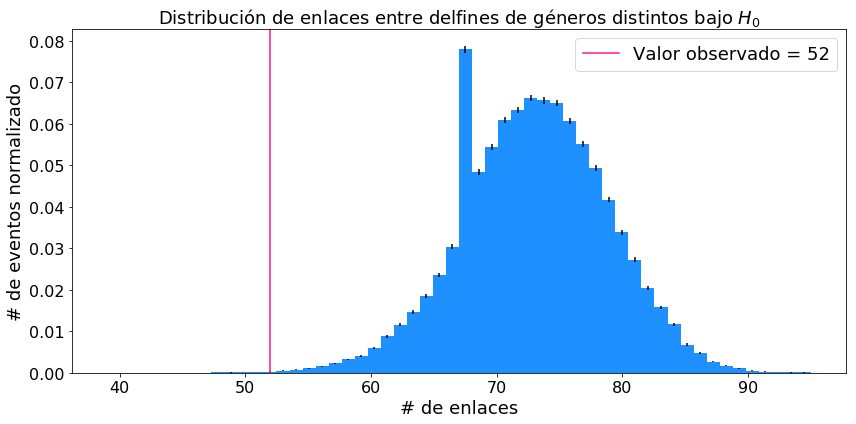

In [143]:
valor_observado = contar_enlaces_entre_grupos(dolph2, 'gender')
fig, ax = plt.subplots(figsize=(12, 6))
ax.axvline(valor_observado, color='deeppink',
           label='Valor observado = {}'.format(valor_observado))
ax.legend(fontsize=18)
histograma(enlaces_entre_grupos, bins=54, density=True, ax=ax,
           titulo=r'Distribución de enlaces entre delfines de géneros distintos bajo $H_0$',
           xlabel='# de enlaces')
plt.show()

Vamos a calcular el p-value. Para eso, integramos el histograma a partir del valor real hasta menos infinito. Como la distribucion es acampanada, duplicamos el valor obtenido para contemplar los valores que se encuentran del otro lado de la distribucion con probabilidad menor que la de del valor real del numero de enlaces.

In [144]:
p_value(enlaces_entre_grupos, 52, 'izq')

0.00107

Esto quiere decir que, si $H_0$ fuera correcta, la probabilidad de haber observado lo que observamos es del 0,1% aproximadamente. Por lo tanto podemos concluir que la topología y los géneros sí están relacionadas.

Finalmente, si bien esto no añade realmente más información, construimos también la distribución de modularidades bajo $H_0$ y la visualizamos. Como calcular modularidades toma más tiempo, para esto realizamos una simulación con menos historias.

In [145]:
n_simulaciones = 1000
modularidades = np.zeros((n_simulaciones))
grafo_h0 = dolph2.copy()
# Vamos a ir modificando este grafo "in place" (no lo clonamos n veces)
for i in range(n_simulaciones):
    # Mezclamos la lista de nombres de delfines.
    # A los primeros 24 delfines les reasignamos género hembra
    # El resto van a ser macho.
    hembras = sample(list(grafo_h0.nodes()), 24)
    for nombre in grafo_h0.nodes():
        if nombre in hembras:
            grafo_h0.nodes()[nombre]['gender'] = 'f'
        else:
            grafo_h0.nodes()[nombre]['gender'] = 'm'
    modularidades[i] = modularidad(grafo_h0, 'gender')

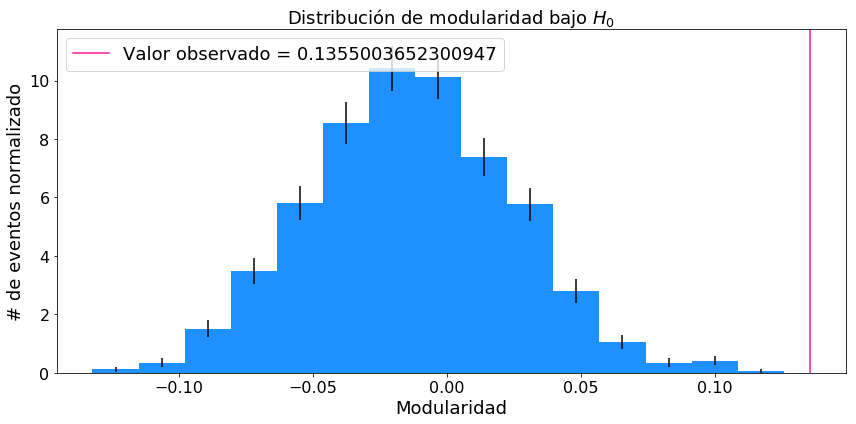

In [147]:
modularidad_observada = modularidad(dolph2, 'gender')
fig, ax = plt.subplots(figsize=(12, 6))
ax.axvline(modularidad_observada, color='deeppink',
           label='Valor observado = {}'.format(modularidad_observada))
ax.legend(fontsize=18)
histograma(modularidades, bins=15, density=True, ax=ax,
           titulo=r'Distribución de modularidad bajo $H_0$',
           xlabel='Modularidad')
plt.show()

# Ejercicio 3

In [156]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.readwrite.gml import read_gml
from __future__ import division
import rpy2.robjects as ro # Al hacer esto se inicializa un subproceso de R
from rpy2.robjects.packages import importr
from histograma import histograma
# Usando importr, importamos paquetes de R que van a funcionar algo 
# así como módulos de Python

internet = read_gml('tc01_data/as-22july06.gml')
nodes = []
degrees = []
for a, b in internet.degree():
    nodes.append(a)
    degrees.append(b)

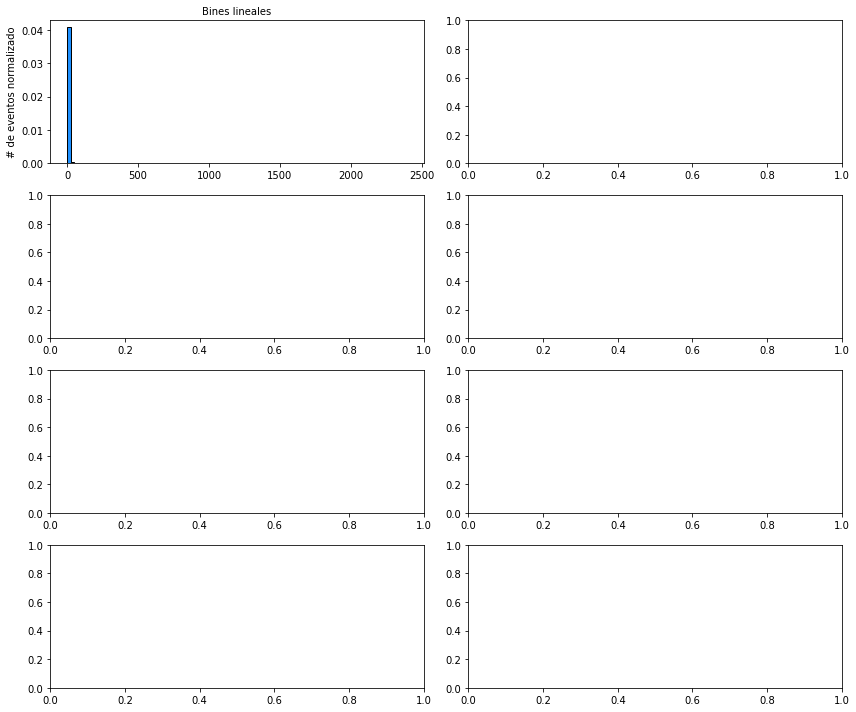

In [157]:
#%% PUNTO A: Comparación de visualizaciones

# Para comparar los bineados logarítmicos y no logarítmicos, lo justo es
# excluir a los nodos de grado 0 en ambos 

fig, axes = plt.subplots(4, 2, figsize=(12,10))
axes = axes.flatten()
logbinss = [0, 0, 0, 0, 1, 1, 1, 1]
logxs    = [0, 0, 1, 1, 0, 0, 1, 1]
logys    = [0, 1, 0, 1, 0, 1, 0, 1]

t = ['Bines lineales', 'Bines logarítmicos']
titulos  = [t[i] for i in logbinss]
xlabels = [('Grado (adim.)' if i in [6,7] else None) for i in range(8)]
ylabels = [(True if i % 2 == 0 else False) for i in range(8)]

for i in range(8):
    histograma(degrees,
               logbins=logbinss[i], logx=logxs[i], logy=logys[i], ax=axes[i],
               titulo=titulos[i], xlabel=xlabels[i], ylabel=ylabels[i],
               ecolor='k', errbars=False, 
               labelsize=10, ticksize=10,
               bins=(1, max(degrees) + 2, 100))

Por alguna razón este código no está haciendo lo que queremos en el notebook, por lo tanto copiamos abajo la imagen con los histogramas pre-generados (con ese mismo código).

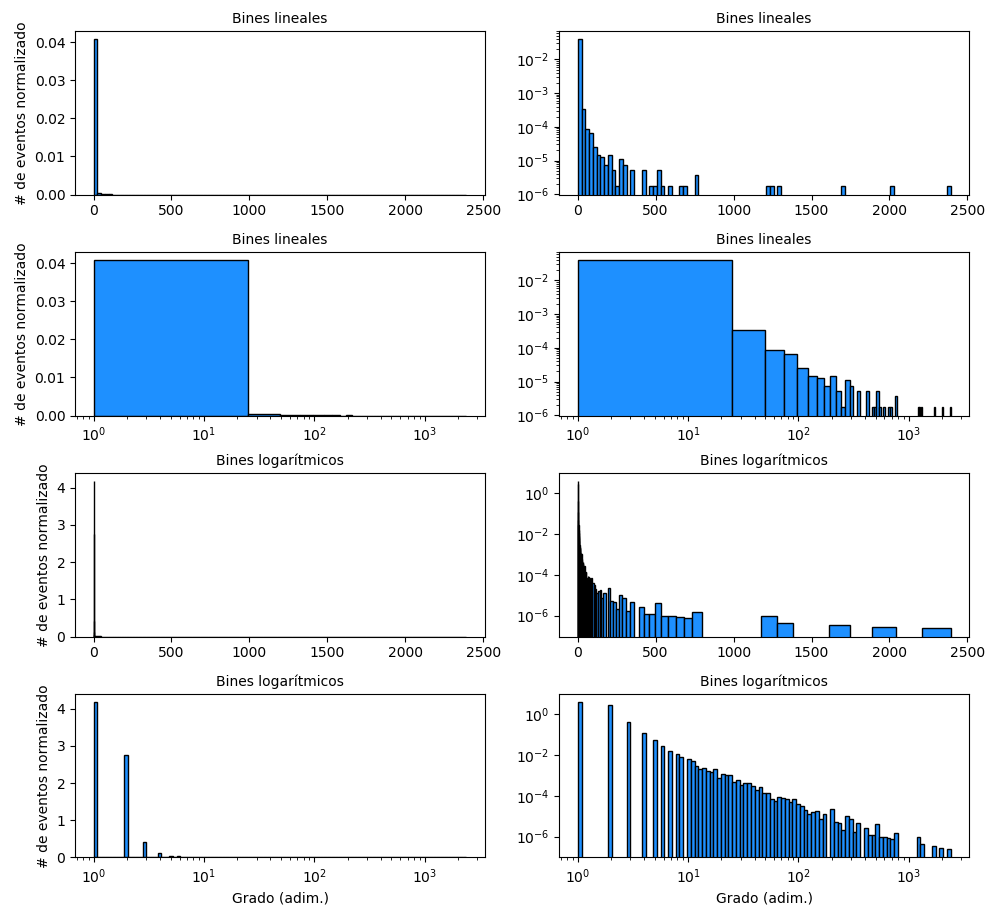

La visualización más adecuada es con bines logarítmicos y escala log-log.

In [158]:
'''Algo interesante de ver es que el 98% de los degrees estan entre los 
degrees 0 y 20:'''
frac = np.sum([d <= 20 for d in degrees]) / len(degrees)
print(frac)

0.9805339023646736


### AJUSTE DE LEY DE POTENCIAS VIA MÉTODO CLAUSET-SHALIZI-NEWMAN

Vamos a llamar a R desde Python usando la librería rpy2

In [4]:
## EJECUTAR ESTO si no tienen instalado el paquete igraph (para instalarlo)
## import rpy2's package module
## select a mirror for R packages
#utils = importr('utils')
#utils.chooseCRANmirror(ind=2) # elijo de dónde descargar el paquete
## Instalo
#from rpy2.robjects.vectors import StrVector
#utils.install_packages(StrVector(['igraph']))

In [5]:
# Realizo el ajuste de la powerlaw
igraph = importr('igraph')
# Creamos un vector de R pasándole los degrees
degrees_r = ro.FloatVector(degrees)
# Documentación de fit_power_law:
# https://rdrr.io/cran/igraph/man/fit_power_law.html
resultado = igraph.fit_power_law(degrees_r, implementation='plfit')
print(resultado.r_repr())

list(continuous = FALSE, alpha = 2.08715666887787, xmin = 5, 
    logLik = -7690.8859032442, KS.stat = 0.0102570630609345, 
    KS.p = 0.969070170897117)


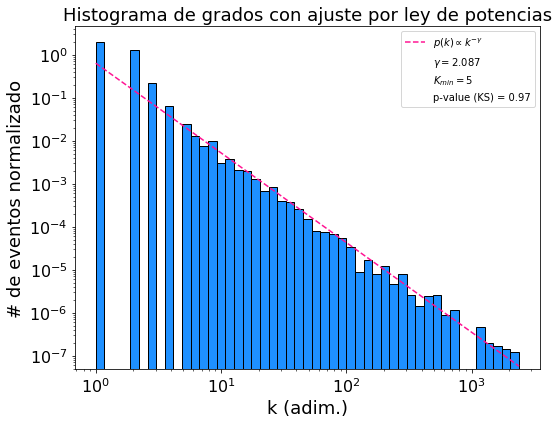

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f31c2252da0>)

In [7]:
# Graficamos histograma + ajuste
kmin = resultado.rx2('xmin')[0]
gamma = resultado.rx2('alpha')[0]
ksp = resultado.rx2('KS.p')[0]

from scipy.special import zeta
def powerlaw(x, gamma, kmin):
    # Como nuestro ajuste fue sobre una distribución de probabilidad discreta,
    # la cte de normalización es 1 sobre la función zeta de Riemann generalizada
    return x**(-gamma) / zeta(gamma, kmin)

# ACLARACION IMPORTANTE
# Para que se grafique bien la ley de potencias, es necesario llamar
# a la función powerlaw poniendo kmin=1. Esto se debe a que el histograma
# de grados está normalizado arrancando desde k=1, y no desde el kmin que
# elige la función fit_power_law.

fig, ax = plt.subplots(figsize=(8,6))
titulo = 'Histograma de grados con ajuste por ley de potencias'
xs = np.linspace(1, max(degrees) + 2, 1000)
ax.plot(xs, powerlaw(xs, gamma, 1), '--', color='deeppink',
        label=r'$p(k) \propto k^{-\gamma}$')
#xs = np.arange(1, max(degrees) + 2)
#ax.plot(xs, powerlaw(xs, gamma, kmin), 'o', color='deeppink',
#        label=r'$\gamma = $' + '{:.4g}'.format(gamma))
ax.plot([], [], ' ', label=r'$\gamma = $' + '{:.4g}'.format(gamma))
ax.plot([], [], ' ', label=r'$K_{min} = $' + '{:.0f}'.format(kmin))
ax.plot([], [], ' ', label='p-value (KS) = {:.2g}'.format(ksp))
ax.legend()

histograma(degrees, logbins=True, ax=ax, titulo=titulo,
           logx=True, logy=True,
           xlabel='k (adim.)', ylabel=True, ecolor='k', errbars=False, 
           labelsize=18, ticksize=16, bins=(1, max(degrees) + 2, 50))


El ajuste es excelente dado que el p-value del test Kolmogorov-Smirnov es 0.97.






# Ejercicio 4

### Punto a
### i)

Primero importamos las librerías que necesitamos, e importamos las redes sobre las cuales vamos a trabajar.

In [8]:
from __future__ import division
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.readwrite.gml import read_gml

from scipy.odr import Model, RealData, ODR
from scipy import stats

from histograma import histograma

In [9]:
net_science = read_gml('tc01_data/netscience.gml')
july = read_gml('tc01_data/as-22july06.gml')

Para calcular el promedio del grado medio de los vecinos de nodos de grado k  ($k_{nn}$), utilizamos la funcion $annd$(). Dada una red, esta función genera 2 listas: una lista con el grado de cada nodo, y una lista con el grado medio de los vecinos ($annd$) de dicho nodo, calculada con nx.average_neighbor_degree(). Notar que estas listas están ordenadas de la misma forma, es decir, la componente i-ésima de ambas listas corresponden al mismo nodo. Luego, la función itera sobre todos los nodos con la condición de que promedie los $annd$ de todos los nodos con igual grado y lo guarde en una lista. Finalmente la función devuelve la lista de grados, y la lista de los promedios de $annd$ por grado.

La funcion nan_delete() remueve los nan y los inf de la lista de los promedios de $annd$s que aparecen por promediar listas vacías.

In [10]:
def nan_delete(k_nn):
    """Remueve los inf y los nan de la lista manteniendo su k especifico.
    .
    .
    """
    k = np.arange(0, len(k_nn), 1)
    k_nn_temp = []
    k_temp = []    
    for i in range(len(k_nn)):
        if not np.isinf(k_nn[i]) and not np.isnan(k_nn[i]) and not np.isinf(k[i]):
            k_nn_temp.append(k_nn[i])
            k_temp.append(k[i])
    return k_temp, k_nn_temp

def annd(red):
    """ annd (average neighbouhr degree distribution) devuelve el annd en orden
    de los grados del nodo.
    
    Returns: k, k_nn
    
    k: array con los grados de la red (eje X)
    k_nn: array con los annd promediados por grado (eje Y)
    .
    .
    """
    nombres = list(red.nodes)
    avnedeg = nx.average_neighbor_degree(red)
    grados = nx.degree(red)
    a = []
    for i in range(max(dict(nx.degree(red)).values())+1):
        b = []
        for j in range(len(nombres)):
            if i == grados[nombres[j]]:
                b.append(avnedeg[nombres[j]])
        a.append(np.mean(b))
    k, k_nn = nan_delete(a)
    return k, k_nn

degree_2, annd_2 = annd(net_science)
degree_1, annd_1 = annd(july)

#OBS: si correr esta celda devuelve un error de Mean of empty slice, o similar, no pasa nada.

/home/gabo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gabo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### ii)

Para observar la tendencia de los $k_{nn}$ graficamos, para cada red, 4 formas distintas de observar los gráficos: la escala lineal, la escala log-log, la cumulativa en escala log-log, y un histograma de los $k_{nn}$. Ambos gráficos fueron generados con la funcón gráficos_multiples(), pasando degree_i como el eje x y annd_i como el eje y.

In [11]:
def graficos_multiples(x, y, network_name):
    f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)
    f.tight_layout()
    f.suptitle(network_name, x=0.53, y = 0.99 ,fontsize=15)

In [12]:
    plt.sca(ax1)
    ax1.set_title('(a)  Lineal')
    ax1.plot(x, y, '.')
    ax1.set_ylabel(r'$k_{nn}$')
    ax1.set_xlabel('k')
    
    plt.sca(ax2)
    ax2.set_title('(b)  Log Log')
    ax2.loglog(x, y, '.')
    ax2.set_ylabel(r'$k_{nn}$')
    ax2.set_xlabel('k')
    #ax2.yscale('log')
    #ax2.xscale('log')
    
    plt.sca(ax3)
    coefs_reversed = np.flip(y, 0)
    cumulative = np.cumsum(coefs_reversed)
    cumulative = np.flip(cumulative, 0)
    ax3.set_title('(c)  Cumulative')
    ax3.loglog(x, cumulative, '.')
    ax3.set_xlabel(r'$k_{nn}$')
    
    plt.sca(ax4)
    ax4.set_title('(d)  Log binned histogram')
    histograma(y, ax=ax4, xlabel=r'$k_{nn}$', labelsize=10, ticksize=10)

graficos_multiples(degree_1, annd_1, 'July')
graficos_multiples(degree_2, annd_2, 'Net_science')

NameError: name 'ax1' is not defined

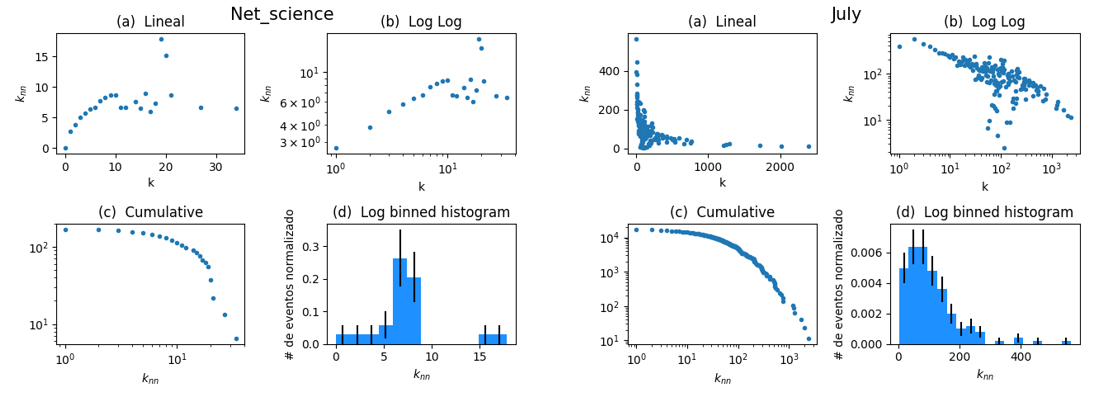

En la red de July se puede observar que decrece el $annd$ promedio a medida que aumenta el grado del nodo. Por otro lado, en la red Net_science el $annd$ promedio aumenta con el grado de los nodos. El análisis de este comportamiento se vera en el punto iv).

### iii)

Se ajustó una recta al logaritmo de $k_{nn}$ en función del logaritmo de k.

In [ ]:
def linear(M, x):
    m, b = M
    return x*m + b

def ajuste_lineal(degree, annd):
    if degree[0] == 0.:
        log_k_nn = [np.log(i) for i in annd[1:]]
        log_k = [np.log(i) for i in degree[1:]]
    else:
        log_k_nn = [np.log(i) for i in annd]
        log_k = [np.log(i) for i in degree]        
    linear_model = Model(linear)
    data = RealData(log_k, log_k_nn)
    odr = ODR(data, linear_model, beta0=[0., 1.])
    out = odr.run()
    log_modelo = [j*out.beta[0]+out.beta[1] for j in log_k]
    return log_k, log_modelo, out.beta[0]

f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout()
f.suptitle('Ajustes lineales', x=0.53, y = 0.99 ,fontsize=15)

plt.sca(ax1)
ax1.set_title('July')
ax1.plot(np.log(degree_1), np.log(annd_1), '.')
ax1.plot(ajuste_lineal(degree_1, annd_1)[0], ajuste_lineal(degree_1, annd_1)[1])
ax1.set_ylabel(r'$k_{nn}$')
ax1.set_xlabel('k')
ax1.text(5, 6.5, r'$\mu$ = %s' % round(ajuste_lineal(degree_1, annd_1)[2], 2))

plt.sca(ax2)
ax2.set_title('Net Science')
ax2.plot(np.log(degree_2), np.log(annd_2), '.')
ax2.plot(ajuste_lineal(degree_2, annd_2)[0], ajuste_lineal(degree_2, annd_2)[1])
ax2.set_ylabel(r'$k_{nn}$')
ax2.set_xlabel('k')
ax2.text(1, 2.5, r'$\mu$ = %s' % round(ajuste_lineal(degree_2, annd_2)[2], 2))

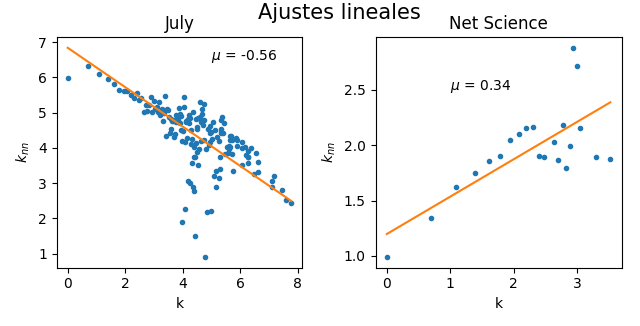

Se puede observar que el exponente de correlación resultó negativo para la red July, mientras que para la red Net science resultó positivo.

### iv)

Finalmente se calculo el coeficiente de asortatividad de Newmann para ambas redes utilizando la funcion de networkx nx.degree_assortativity_coefficient(), como se puede observar en la siguiente tabla.

In [13]:
data = pd.DataFrame({"Red": ['July','Net Science'],
                     "Newmann":[-0.198,0.46],
                     "Barabasi":[-0.56 ,0.34],
                    })#empty dataframe
data

,Red,Newmann,Barabasi
0,July,-0.198,-0.56
1,Net Science,0.460,0.34


Para las dos redes, ambos estimadores no solo resultaron del mismo orden, sino que también tienen el mismo signo. El hecho de que el estimador de Newmann dé negativo indica que la red es disortativa, mientras que si resulta positivo la red es asortativa. 

En este caso, la propiedad de la red que se esta estudiando es el promedio del $annd$ por grado ($k_{nn}$). Por lo tanto, que la red sea asortativa en este aspecto indica que los nodos con alto grado se van a relacionar con nodos de alto grado, mientras que los nodos con grado bajo se van a relacionar con nodos de grado bajo. Es decir, en general los vecinos de los nodos de alto grado van a tener a su vez un grado alto, por lo que su $annd$ va a ser elevado; y los nodos de grado bajo van a tener vecinos con grado bajo, por lo que su $annd$ va a ser pequeño en comparación a los anteriores.

Este estimador es a su vez consistente con el estimador de Barabási, que indica una pendiente positiva en el $k_{nn}$ por grado, para redes asortativas. Es decir, a medida que aumento el grado, también voy a aumentar el $k_{nn}$.

Por el contrario, para redes disortativas va a ocurrir lo contrario. Los nodos con alto grado se van a relacionar en general con nodos de grado bajo, y viceversa. Por lo tanto, el $annd$ de los nodos de grado alto va a ser pequeño, ya que sus vecinos van a tener grado bajo, mientras que el $annd$ de los nodos de grado bajo va a ser grande en general, ya que van a estar relacionados con nodos de grado alto resultando en un elevado $annd$.

De nuevo, este estimador es consistente con el estimador de barabási. Para estas redes indica una pendiente negativa en el $k_{nn}$ por grado. Es decir, a medida que aumento el grado del nodo, en promedio el $annd$ va a decrecer. 

### Punto b


En este punto corremos los mismos codigos que en el Punto a, pero para las redes de proteínas g_y2h y g_apms.

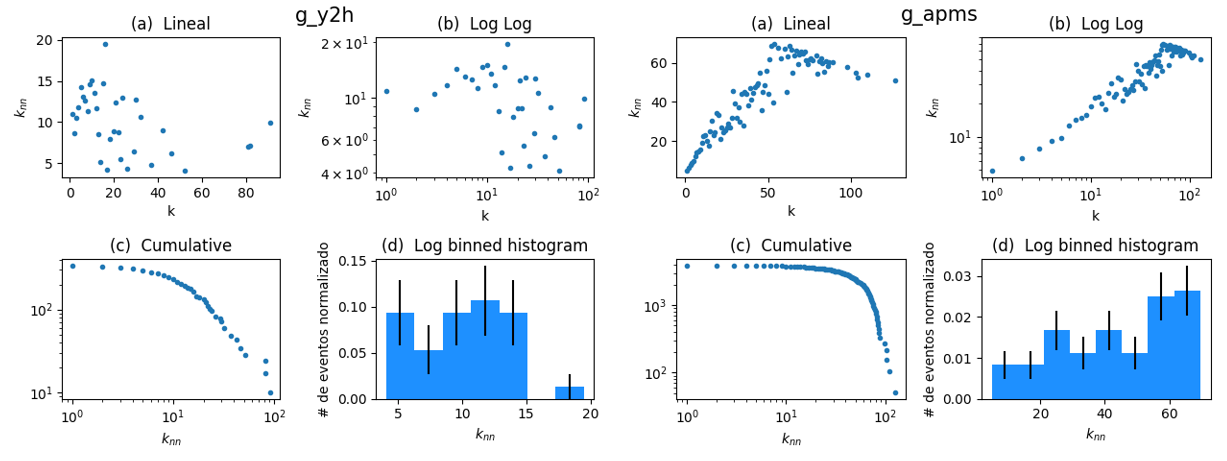

Luego, si se ajustan los graficos log-log por rectas, se observa que la red g_y2h tiene una pendiente negativa, mientras que la red g_apms tiene una pendiente positiva.

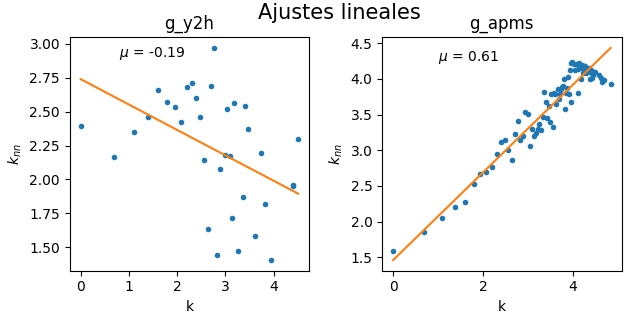

Por otro lado, si se calcula el coeficiente de asortatividad de Newmann para ambas redes, resulta

In [14]:
data = pd.DataFrame({"Red": ['g_y2h','g_apms'],
                     "Newmann":[-0.06,0.61],
                     "Barabasi":[-0.19 ,0.61],
                    })#empty dataframe
data


,Red,Newmann,Barabasi
0,g_y2h,-0.06,-0.19
1,g_apms,0.61,0.61


Nuevamente, los coeficientes resultan del mismo orden y del mismo signo para los dos métodos. Luego, se puede concluir que la red g_apms es una red asortativa, donde en promedio los nodos con alto $annd$ se relacionan con nodos de alto $annd$, mientras que los nodos de bajo $annd$ se relacionan con nodos de bajo $annd$. Por otro lado, la red g_y2h es una red disortativa en la cual los nodos de bajo grado tienden a relacionarse con nodos de alto $annd$ en promedio, y los nodos de grado alto tienden a relacionarse con nodos de bajo $annd$ en promedio.